In [1]:
%matplotlib inline

In [2]:
import numpy as np # Who does not use Numpy?
import re

import matplotlib
# old_backend =  matplotlib.get_backend() 
# matplotlib.use("Agg")  # Prevent showing stuff

from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt # Plotting
from matplotlib.colors import LogNorm # Look up table
from matplotlib.colors import PowerNorm # Look up table
import matplotlib.colors as mcolors

font = {'family' : 'serif',
        #'weight' : 'bold',
         'size'   : 22
       }
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

import SimpleITK as sitk
import spekpy as sp
import gvxrPython3 as gvxr

Read the DICOM file

In [3]:
reader = sitk.ImageFileReader()
reader.SetImageIO("GDCMImageIO")
reader.SetFileName("data/DX000000")
reader.LoadPrivateTagsOn()
reader.ReadImageInformation()    
volume = reader.Execute()
real_image = sitk.GetArrayFromImage(volume)[0]

In [4]:
# meta_data_keys = volume.GetMetaDataKeys()

# print("DICOM fields:")
# for key in meta_data_keys:
#     print(key, volume.GetMetaData(key))

In [5]:
# def cleanTags(raw_string):
#     regular_expression = re.compile('<.*?>')
#     clean_text = re.sub(regular_expression, '', raw_string)
#     return clean_text


In [6]:



# field = volume.GetMetaData("0033|1022")

# for item in field.split("\n"):
#     if "KV" in item:
#         kv = float(cleanTags(item))
        

# print(kv)


In [9]:
spacing = volume.GetSpacing()[0:2]
size = volume.GetSize()[0:2]

In [15]:
kVp = float(volume.GetMetaData("0018|0060"))
print("Peak kilo voltage output of the x-ray generator used: ", kVp)

Peak kilo voltage output of the x-ray generator used:  89.9


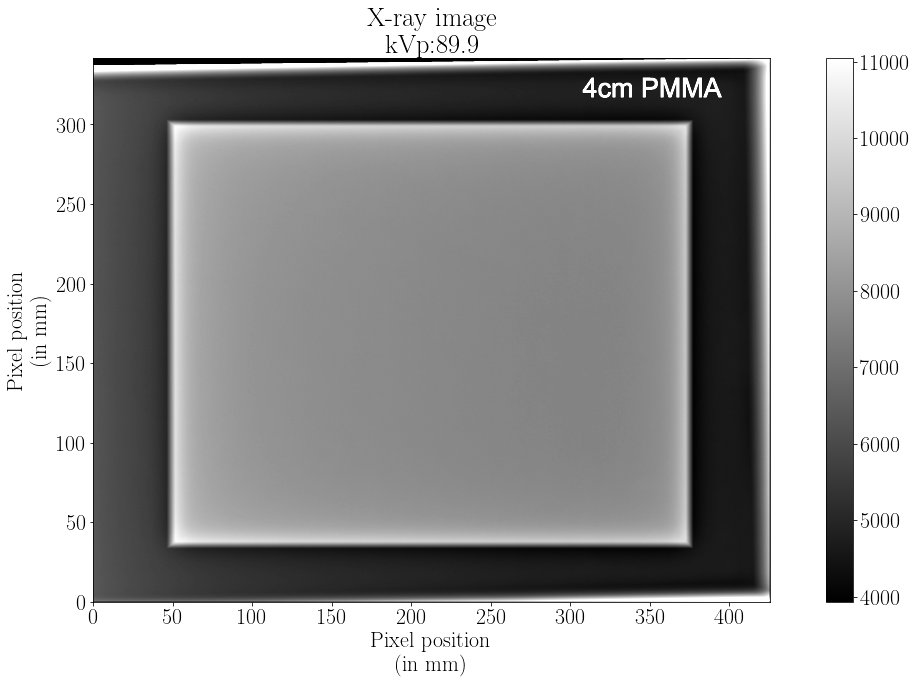

In [14]:
plt.figure(figsize= (20,10))
xrange=range(real_image.shape[1])
yrange=range(real_image.shape[0])

plt.xlabel("Pixel position\n(in mm)")
plt.ylabel("Pixel position\n(in mm)")
plt.title("X-ray image\nkVp:" + str(kVp))
plt.imshow(real_image, cmap="gray", 
           vmin=3934, vmax = 11045,
           extent=[0,(real_image.shape[1]-1)*spacing[0],0,(real_image.shape[0]-1)*spacing[1]])
plt.colorbar(orientation='vertical')

In [16]:
window_size =  [800, 450]
source_position = [0.0, 0.0, 1000.0, "mm"]
detector_position = [0.0, 0.0, -125.0, "mm"]
detector_up = [0, 1, 0]

gvxr.makeCube("PMMA block",
        4.0,
        "cm")
gvxr.setCompound("PMMA block", "C5O2H8")

gvxr.setDensity("PMMA block", 1.18, "g/cm3")

gvxr.addPolygonMeshAsInnerSurface("PMMA block")

In [17]:
# Create an OpenGL context
print("Create an OpenGL context:",
    str(window_size[0]) + "x" + str(window_size[1])
);
gvxr.createOpenGLContext();
gvxr.setWindowSize(
    window_size[0],
    window_size[1]
);


Create an OpenGL context: 800x450
gvxrStatus:	Create window 0
gvxrStatus:	Create window 
0 0 500 500
OpenGL renderer:   NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2
OpenGL version:    3.2.0 NVIDIA 470.42.01
OpenGL vender:     NVIDIA Corporation
Use OpenGL 4.5.
0 0 800 450


In [18]:
# Set up the beam
print("Set up the beam")
print("\tSource position:", source_position)
gvxr.setSourcePosition(
    source_position[0],
    source_position[1],
    source_position[2],
    source_position[3]
);

gvxr.usePointSource();

focal_spot_size = volume.GetMetaData("0018|1413")
# gvxr.setFocalSpot(focal_spot_size, focal_spot_size, focal_spot_size, "mm");
print("size of focal spot (in mm):", focal_spot_size)

Set up the beam
	Source position: [0.0, 0.0, 1000.0, 'mm']
size of focal spot (in mm): 11.653


# Get the spectrum from the DICOM file

In [19]:
spectrum = {};

s = sp.Spek(kvp=kVp)
# s.filter(filter_material, filter_thickness_in_mm) # Filter by 4 mm of Al
unit = "keV"
k, f = s.get_spectrum(edges=True) # Get the spectrum

min_energy = sys.float_info.max
max_energy = -sys.float_info.max

for energy, count in zip(k, f):
    count = round(count)

    if count > 0:

        max_energy = max(max_energy, energy)
        min_energy = min(min_energy, energy)

        if energy in spectrum.keys():
            spectrum[energy] += count
        else:
            spectrum[energy] = count

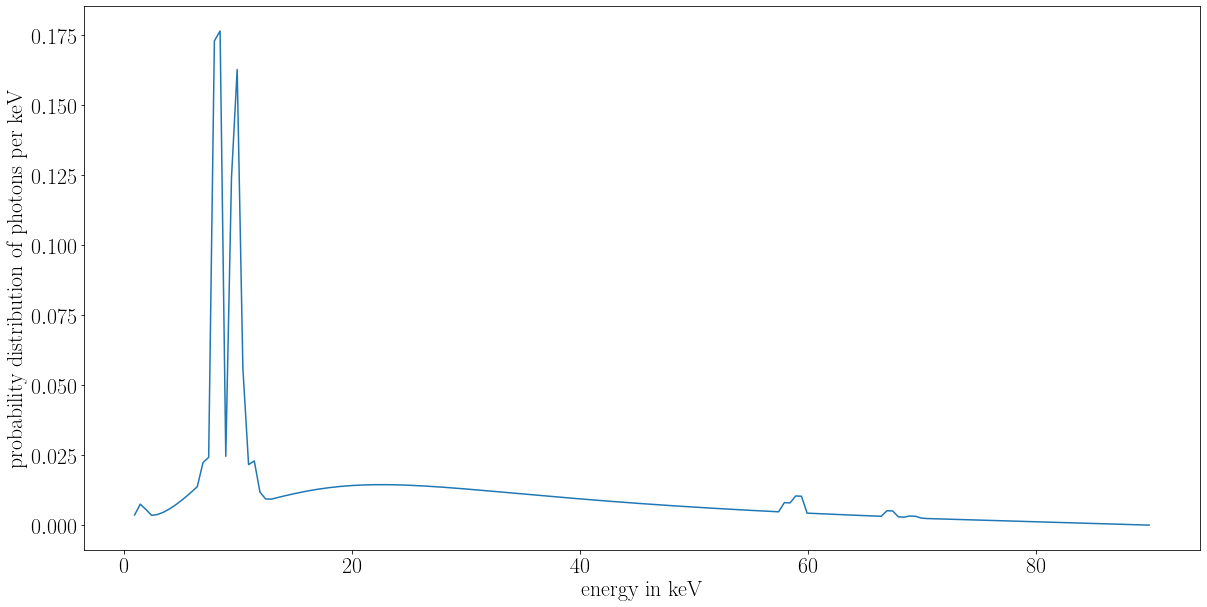

In [20]:
# get the integral nb of photons
nbphotons=0.
energy1 = -1.
energy2 = -1.

for energy in spectrum.keys():
    
    if energy1<0:
        energy1 = float(energy)
    elif energy2<0:
        energy2 = float(energy)
    nbphotons += float(spectrum[energy])
sampling = (energy2-energy1)

# get spectrum
data = []
for energy in spectrum.keys():
    source = [float(energy),float(spectrum[energy])/(nbphotons*sampling)]
    data.append(source)

# plot spectrum
plt.figure(figsize= (20,10))

data_array = np.array(data)

x, y = data_array.T
plt.plot(x,y)
plt.xlabel('energy in keV')
plt.ylabel('probability distribution of photons per keV')

plt.savefig("spectrum.pdf")

In [21]:
for energy in spectrum.keys():
    count = spectrum[energy]
    gvxr.addEnergyBinToSpectrum(energy, unit, count);

In [22]:
# Set up the detector
print("Set up the detector");
print("\tDetector position:", detector_position)
gvxr.setDetectorPosition(
    detector_position[0],
    detector_position[1],
    detector_position[2],
    detector_position[3]
);

print("\tDetector up vector:", detector_up)
gvxr.setDetectorUpVector(
    detector_up[0],
    detector_up[1],
    detector_up[2]
);

Set up the detector
	Detector position: [0.0, 0.0, -125.0, 'mm']
	Detector up vector: [0, 1, 0]


In [ ]:
print("\tDetector number of pixels:", size)
gvxr.setDetectorNumberOfPixels(
    size[0],
    size[1]
);

print("\tPixel spacing:", spacing)
gvxr.setDetectorPixelSize(
    spacing[0],
    spacing[1],
    "mm"
);

In [ ]:
gvxr.displayScene()

gvxr.useLighing()
gvxr.useWireframe()
gvxr.setZoom(719.6787109375)
gvxr.setSceneRotationMatrix([0.7624880075454712, 0.09040657430887222, -0.6406543850898743, 0.0,
                             0.05501500517129898, 0.9775413870811462, 0.20342488586902618, 0.0,
                             0.6446591019630432, -0.190354123711586, 0.7403913140296936, 0.0,
                             0.0, 0.0, 0.0, 1.0])

gvxr.displayScene()

In [ ]:
screenshot = gvxr.takeScreenshot()

In [ ]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig('plots/screenshot-beam-off.pdf')
plt.savefig('plots/screenshot-beam-off.png')

In [ ]:
x_ray_image = np.array(gvxr.computeXRayImage())

In [ ]:
total_energy = 0.0
for energy, count in zip(energy_set, count_set):
    total_energy += energy * count

In [ ]:
white = np.ones(x_ray_image.shape) * total_energy / 1000.0
dark = np.zeros(x_ray_image.shape)

x_ray_image = (x_ray_image - dark) / (white - dark)

In [ ]:
plt.figure(figsize= (20,10))

plt.suptitle("Image simulated using gVirtualXRay without the energy response of the detector", y=1.02)

plt.subplot(121)
plt.imshow(x_ray_image, cmap="gray", vmin=0.25, vmax=1)
plt.colorbar(orientation='horizontal')
plt.title("Using a linear colour scale")

plt.subplot(122)
plt.imshow(x_ray_image, norm=PowerNorm(gamma=1./0.75), cmap="gray")
plt.colorbar(orientation='horizontal')
plt.title("Using a Power-law colour scale")

plt.tight_layout()

plt.savefig('plots/x_ray_image_without_detector_response.pdf')
plt.savefig('plots/x_ray_image_without_detector_response.png')